In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pyslabgrid.circ as circ
import pyslabgrid.slabrup as slabrup
from scipy.interpolate import interp1d
from scipy.interpolate import PPoly

In [2]:
# Aug 2, 2022 - revised with bounds 45 degrees instead of 90 degrees 
# for more rigourous classification of strikes

dump_hik = slabrup.get_GeoNetevents('hik')
dump_puy = slabrup.get_GeoNetevents('puy')
slabevents = {'hik': dump_hik, 'puy': dump_puy}

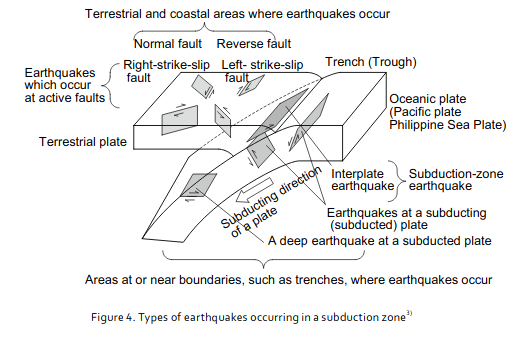

https://www.jaso.jp/pdf/earthquake_resistant.pdf

In [3]:
critical_dip = {'hik': 45, 'puy': 45}
# trnsition dip for strike-chnage
# process_strikediprake(slabevents, szone, critical_dip=None):
dump_hik = slabrup.process_strikediprake(slabevents, 'hik', critical_dip=critical_dip)
dump_puy = slabrup.process_strikediprake(slabevents, 'puy', critical_dip=critical_dip)
procslabevents  = {'hik': dump_hik, 'puy': dump_puy,}

print(len(slabevents['hik']['strike1']))
print(len(slabevents['puy']['strike1']))

399
76


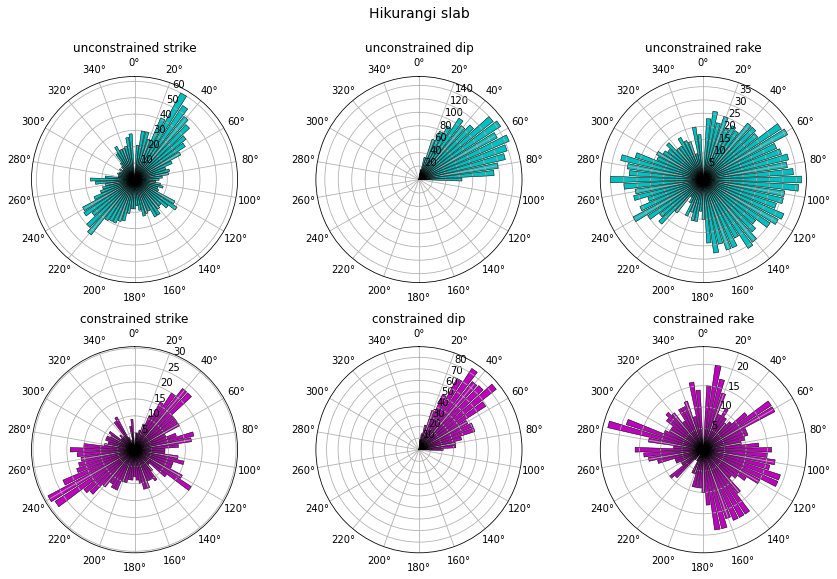

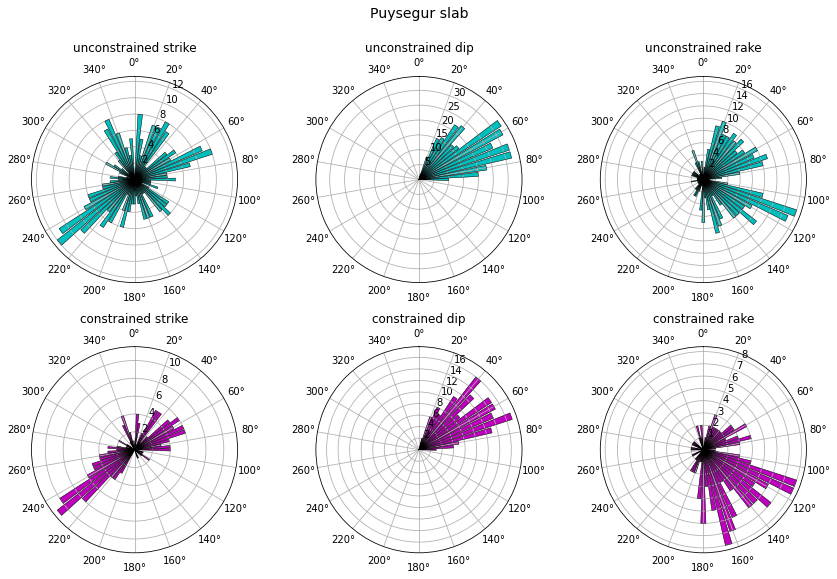

In [4]:
# let us see how the strike, dip & rakes looks like
dump_hik = slabrup.get_allstrikediprakes(slabevents, 'hik')
dump_puy = slabrup.get_allstrikediprakes(slabevents, 'puy')
xslabevents = {'hik': dump_hik, 'puy': dump_puy}

slabrup.review_strikediprake(xslabevents, procslabevents, 'hik')
plt.show()
slabrup.review_strikediprake(xslabevents, procslabevents, 'puy')

In [5]:
def binned_strikes(x, y, fbs =10, min_x = 20, max_x = 300, doplot=True,
                       strtitle='', xlabel='depth (km)', ylabel = '', ax = None):
    # plot y according to binnned x
    x_bin = [d for d in range(min_x, max_x, fbs)]
    xbox  ={}
    x_means, x_std = [], []
    
    for xb in x_bin:
        kx =[]
        for xx, yy in zip(x, y):
            if (xx>=(xb-fbs)) & (xx<(xb+fbs)):
                kx.append(yy)
        if len(kx)<4:
            x_means.append(float("nan"))
            x_std.append(float("nan"))
        else:
            cmean, cstd = circ.meanstats(kx, high=360, stdev=True)
            x_means.append(cmean)
            x_std.append(cstd)
       #  x_val.append(xb)
    # returns mean, mean+std, mean-std
        xbox.update({xb:kx})
    if doplot:
        if ax is None:
            if max_x==300:
                fig, ax = plt.subplots(figsize=(17,2))
            else:
                fig, ax = plt.subplots(figsize=(17,1.2))
          
        X = range(1, len(x_bin)+1)
        ax.errorbar(X, x_means, color = 'k', xerr = None, linewidth= 0.5,
                    yerr = x_std, ls='none', markerfacecolor='none', 
                     capsize=5)
        ax.plot(X,x_means,'ko', markersize=10)
        #for dat,x in zip(data,X):
        #  plt.text(x,70, str(len(dat)))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_yticks([30, 140, 250, 360])
       
        #xx_bin = [d for d in range(min_x, 300, fbs)]
        # XX = range(1, len(xx_bin)+1)
        ax.set_xticks([x for x in X])
        ax.set_xticklabels([str(xx) for xx in x_bin])
        ax.set_title(strtitle, fontsize=13)
        #ax.set_xlim([0.5, 28+0.5])
        
    return xbox

In [6]:
def evalute_strikediprake_depbin(szone, xslabevents):
    stitle = {'hik': 'Hikurangi Slab', 'puy': 'Puysegur slab'}
    
    
    if szone=='hik': 
        fbs, min_x,max_x  =10, 20, 300
    else:
        fbs, min_x,max_x  =10, 20, 200
    
    if szone=='hik':
        fig = plt.figure(1, figsize=(13,8))
    else:
        fig = plt.figure(1, figsize=(10,8))
    plt.rcParams.update({'font.size': 13})
    ax1 = fig.add_subplot(311)
    xbox_strike = binned_strikes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['strike'], fbs =fbs, min_x = min_x, max_x = max_x,
                        strtitle='', ylabel='strike (deg)', ax =ax1);
   
    
    
    ax2 = fig.add_subplot(312)
    xbox_dip = slabrup.binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['dip'], fbs =fbs, min_x = min_x, max_x = max_x,
                        strtitle='', ylabel='dip (deg)', ax =ax2);
    ax3 = fig.add_subplot(313)
    slabrup.binned_boxes(xslabevents[szone]['dep'], 
                        xslabevents[szone]['rake'], fbs =fbs, min_x = min_x, max_x = max_x,
                         strtitle='', ylabel='rake (deg)', ax=ax3);
    
    if szone=='hik':
        ax1.set_xlim([0.5, 24.5])
        ax2.set_xlim([0.5, 24.5])
        ax3.set_xlim([0.5, 24.5])
    else:
        ax1.set_xlim([0.5, 15.5])
    
    fig.suptitle(stitle[szone], fontsize=12, y=0.97) 
    
  #  fbs, min_x,max_x  =10, 20, 300
    x_bin = [d for d in range(min_x, max_x, fbs)]
    
    X, Y, Ystd = [], [],[] 
    for db in xbox_strike.keys():
        ky = xbox_strike[db]
        if len(ky)<5:
            continue
        cmean, cstd = circ.meanstats(ky, high=360, stdev=True)
        Y.append(cmean)
        Ystd.append(cstd)
        X.append(db)
    if szone =='puy':
        Y.append(cmean)
        Ystd.append(cstd)
        X.append(290)
    X = np.array(X)
    
    strike_interp = interp1d(X, np.array(Y))
    strikestd_interp = interp1d(X, np.array(Ystd))
    
    bstrikes = []
    kstrikes = {}
    for db in x_bin:
        bstrikes.append([db, round(strike_interp(db).tolist()), round(strikestd_interp(db).tolist())])
        kstrikes.update({db:[round(strike_interp(db).tolist()), round(strikestd_interp(db).tolist())]})
    tS = np.array(bstrikes)
    ax1.errorbar([x  for x in range(1,len(x_bin)+1)], tS[:,1], ls= '--',
                 yerr = tS[:,2], color='g', linewidth=0.2, capsize=5)
    X, Y1 = [], []
    
    for db in xbox_dip.keys():
        ky = xbox_dip[db]
        # if len(ky)<5:
        #    continue
        mean_dip = np.median(ky)
        
        if szone=='hik':
            if ((db>=60) & (db<=100)) & (mean_dip<70):
                # print(db)
                mean_dip =70
                
        Y1.append(mean_dip)
        X.append(db)
    if szone =='puy':
        Y1.append(60)
        X.append(60)
        Y1.append(mean_dip)
        X.append(290)
    
    X = np.array(X)
    dip_interp = interp1d(X, np.array(Y1))
    bdips = []
    kdips = {}
    for db in x_bin:
        bdips.append([db, dip_interp(db).tolist()])
        kdips.update({db: dip_interp(db).tolist()})
    tS = np.array(bdips)
    ax2.plot([x  for x in range(1,len(x_bin)+1)], tS[:,1], '--', color='g', linewidth=0.5)
    
    #szone: {dep: [[s1, d1, r1, p1], [s2, d2, r2, p2], .... ]}
    
    dep_sdrp ={}
    for db in x_bin:
        sdrp = []
        s2, stdstk =kstrikes[db]
        fdip = kdips[db]
        s1 = s2-stdstk
        if s1<0:
            s1=360+s1
        sdrp.append([s1, fdip, -90, 0.32])
        sdrp.append([s2, fdip, -90, 0.36])
        s3 = s2+stdstk
        if s3>360:
            s3=s3-360
        sdrp.append([s3, fdip, -90, 0.32])
        dep_sdrp.update({db:sdrp})
    #slabrupgeom = {szone: dep_sdrp}
    fig.tight_layout()
    return dep_sdrp
    

/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


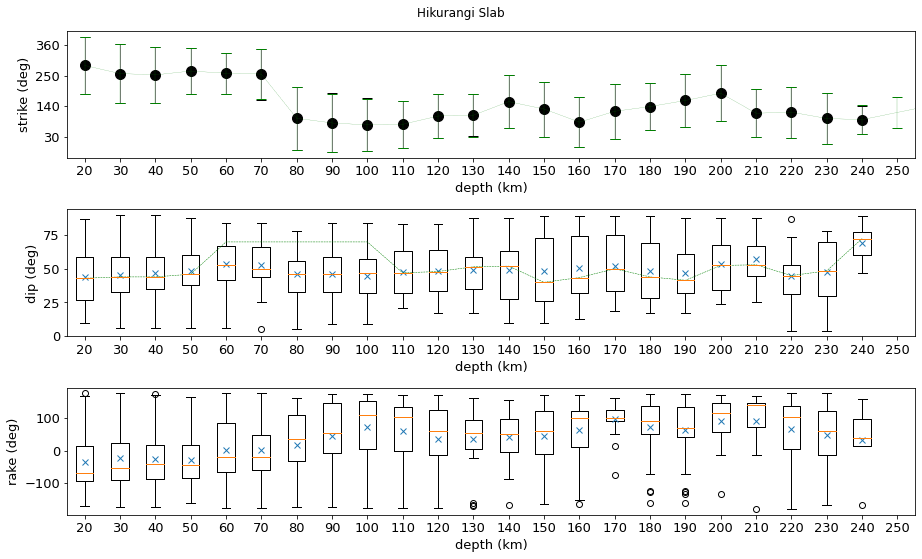

In [7]:
slabrupgeom_hik = evalute_strikediprake_depbin('hik', procslabevents);

/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kirant/openquake/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


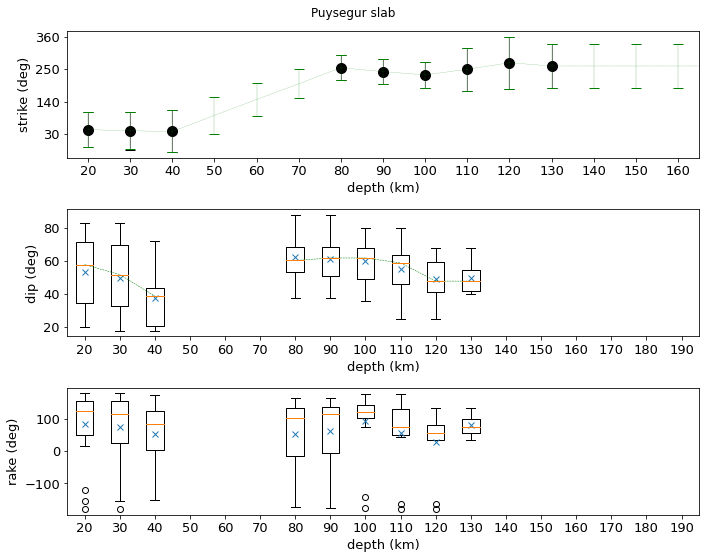

In [8]:
slabrupgeom_puy = evalute_strikediprake_depbin('puy', procslabevents);

In [9]:
slabrupgeom_hik

{20: [[184, 43.0, -90, 0.32], [287, 43.0, -90, 0.36], [30, 43.0, -90, 0.32]],
 30: [[153, 44.0, -90, 0.32], [258, 44.0, -90, 0.36], [3, 44.0, -90, 0.32]],
 40: [[153, 44.0, -90, 0.32], [253, 44.0, -90, 0.36], [353, 44.0, -90, 0.32]],
 50: [[184, 46.0, -90, 0.32], [267, 46.0, -90, 0.36], [350, 46.0, -90, 0.32]],
 60: [[186, 70.0, -90, 0.32], [259, 70.0, -90, 0.36], [332, 70.0, -90, 0.32]],
 70: [[165, 70.0, -90, 0.32], [256, 70.0, -90, 0.36], [347, 70.0, -90, 0.32]],
 80: [[344, 70.0, -90, 0.32], [97, 70.0, -90, 0.36], [210, 70.0, -90, 0.32]],
 90: [[334, 70.0, -90, 0.32], [80, 70.0, -90, 0.36], [186, 70.0, -90, 0.32]],
 100: [[338, 70.0, -90, 0.32], [73, 70.0, -90, 0.36], [168, 70.0, -90, 0.32]],
 110: [[350, 47.0, -90, 0.32], [75, 47.0, -90, 0.36], [160, 47.0, -90, 0.32]],
 120: [[25, 48.0, -90, 0.32], [105, 48.0, -90, 0.36], [185, 48.0, -90, 0.32]],
 130: [[31, 51.5, -90, 0.32], [108, 51.5, -90, 0.36], [185, 51.5, -90, 0.32]],
 140: [[61, 52.0, -90, 0.32], [157, 52.0, -90, 0.36], [25

In [10]:
slabrupgeom = {'hik': slabrupgeom_hik, 'puy': slabrupgeom_puy}
import json
with open("slab-faulting.json", "w") as f:
    json.dump(slabrupgeom, f) 
    
print(slabrupgeom)

{'hik': {20: [[184, 43.0, -90, 0.32], [287, 43.0, -90, 0.36], [30, 43.0, -90, 0.32]], 30: [[153, 44.0, -90, 0.32], [258, 44.0, -90, 0.36], [3, 44.0, -90, 0.32]], 40: [[153, 44.0, -90, 0.32], [253, 44.0, -90, 0.36], [353, 44.0, -90, 0.32]], 50: [[184, 46.0, -90, 0.32], [267, 46.0, -90, 0.36], [350, 46.0, -90, 0.32]], 60: [[186, 70.0, -90, 0.32], [259, 70.0, -90, 0.36], [332, 70.0, -90, 0.32]], 70: [[165, 70.0, -90, 0.32], [256, 70.0, -90, 0.36], [347, 70.0, -90, 0.32]], 80: [[344, 70.0, -90, 0.32], [97, 70.0, -90, 0.36], [210, 70.0, -90, 0.32]], 90: [[334, 70.0, -90, 0.32], [80, 70.0, -90, 0.36], [186, 70.0, -90, 0.32]], 100: [[338, 70.0, -90, 0.32], [73, 70.0, -90, 0.36], [168, 70.0, -90, 0.32]], 110: [[350, 47.0, -90, 0.32], [75, 47.0, -90, 0.36], [160, 47.0, -90, 0.32]], 120: [[25, 48.0, -90, 0.32], [105, 48.0, -90, 0.36], [185, 48.0, -90, 0.32]], 130: [[31, 51.5, -90, 0.32], [108, 51.5, -90, 0.36], [185, 51.5, -90, 0.32]], 140: [[61, 52.0, -90, 0.32], [157, 52.0, -90, 0.36], [253, 5